In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymongo
from bson.objectid import ObjectId

In [2]:
cl = pymongo.MongoClient()
db = cl.sacred

In [3]:
runs = db.runs.find({"experiment.name": "cartpole-vpg-hyperparam-001"})
returns = db.metrics.find({"name" : "cartpole-vpg-hyperparam-001.avg_return"})
print(returns.count())

180


/Users/btimar/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
base_name = "cartpole-vpg-hyperparam-001"

In [5]:
def get_info_by_hyperparams(lr, discount, batch_size):
    experiments = db.runs.find({"experiment.name": base_name, 
                        "config.lr": lr, 
                        "config.discount" : discount, 
                        "config.batch_size": batch_size})
    return_ids = []
    loss_ids = []
    exps = []
    for ex in experiments:
        exps.append(ex)
        metrics = ex['info']['metrics']
        for m in metrics:
            if 'loss' in m['name']:
                loss_ids.append(ObjectId(m['id']))
            elif 'avg_return' in m['name']:
                return_ids.append(ObjectId(m['id']))
            else:
                raise ValueError
    if len(return_ids) != 5:
        raise ValueError
    return exps, return_ids, loss_ids
                
def get_returns_by_hyperparams(lr, discount, batch_size):
    exps, return_ids, loss_ids = get_info_by_hyperparams(lr, discount, batch_size)
    metrics = [ db.metrics.find_one( {"_id": i }) for i in return_ids ]
    episodes = exps[0]["config"]["episodes"]
    batch_size_edge = episodes % batch_size
    if batch_size_edge == 0:
        batch_size_edge = batch_size
    steps = np.asarray(metrics[0]['steps'])
    
    steps[:-1] = steps[:-1] * batch_size
    steps[-1] = steps[-2] + batch_size_edge
    
    vals = [m['values'] for m in metrics]
    return steps, vals

In [6]:
def assign_quality(return_traces):
    return np.mean(np.concatenate([r[-1:] for r in return_traces ]))

In [7]:
best_score = 0
best_params = {}
for lr in [.001, .01, .1]:
    for discount in [.5, .9, 1.0]:
        for batch_size in [1, 5, 10, 20]:
            steps, traces = get_returns_by_hyperparams(lr, discount, batch_size)
            score = assign_quality(traces)
            print("lr {0:.3f}, discount {1:.1f}, batch size {2} has score {3}".format(lr, discount, batch_size, score))
            if score > best_score:
                best_score = score
                best_params=dict(lr=lr, discount=discount, batch_size=batch_size)

lr 0.001, discount 0.5, batch size 1 has score 161.0
lr 0.001, discount 0.5, batch size 5 has score 47.84000015258789
lr 0.001, discount 0.5, batch size 10 has score 29.620000076293945
lr 0.001, discount 0.5, batch size 20 has score 23.34000015258789
lr 0.001, discount 0.9, batch size 1 has score 163.2
lr 0.001, discount 0.9, batch size 5 has score 50.75999908447265
lr 0.001, discount 0.9, batch size 10 has score 30.1200008392334
lr 0.001, discount 0.9, batch size 20 has score 27.029999923706054
lr 0.001, discount 1.0, batch size 1 has score 177.4
lr 0.001, discount 1.0, batch size 5 has score 49.880000305175784
lr 0.001, discount 1.0, batch size 10 has score 31.24000015258789
lr 0.001, discount 1.0, batch size 20 has score 25.75
lr 0.010, discount 0.5, batch size 1 has score 47.2
lr 0.010, discount 0.5, batch size 5 has score 129.52000007629394
lr 0.010, discount 0.5, batch size 10 has score 162.66000213623047
lr 0.010, discount 0.5, batch size 20 has score 147.9200012207031
lr 0.010,

In [8]:
print(best_params)

{'lr': 0.001, 'discount': 1.0, 'batch_size': 1}


In [9]:
import json
with open("best_hyperparams.json", 'w') as f:
    json.dump(best_params, f)

In [11]:
steps, vals = get_returns_by_hyperparams(best_params['lr'], best_params['discount'], best_params['batch_size'])

Text(0.5, 1.0, 'Avg reward')

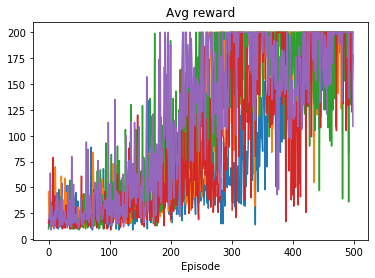

In [12]:
fig, ax = plt.subplots()
for v in vals:
    ax.plot(steps, v)
ax.set_xlabel("Episode")
ax.set_title("Avg reward")